# Kaggle Project

## Describe Your Dataset

**URL:** https://www.kaggle.com/datasets/yasserh/wine-quality-dataset/

**Task:**

...

...

**Datasets**

* Train dataset: ...

* Validation dataset: ...

* Test dataset: ...

**Features(x):**

...

...

**Target(y):**

...

...

---

       fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1143.000000       1143.000000  1143.000000     1143.000000   
mean        8.311111          0.531339     0.268364        2.532152   
std         1.747595          0.179633     0.196686        1.355917   
min         4.600000          0.120000     0.000000        0.900000   
25%         7.100000          0.392500     0.090000        1.900000   
50%         7.900000          0.520000     0.250000        2.200000   
75%         9.100000          0.640000     0.420000        2.600000   
max        15.900000          1.580000     1.000000       15.500000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  1143.000000          1143.000000           1143.000000  1143.000000   
mean      0.086933            15.615486             45.914698     0.996730   
std       0.047267            10.250486             32.782130     0.001925   
min       0.012000             1.000000         

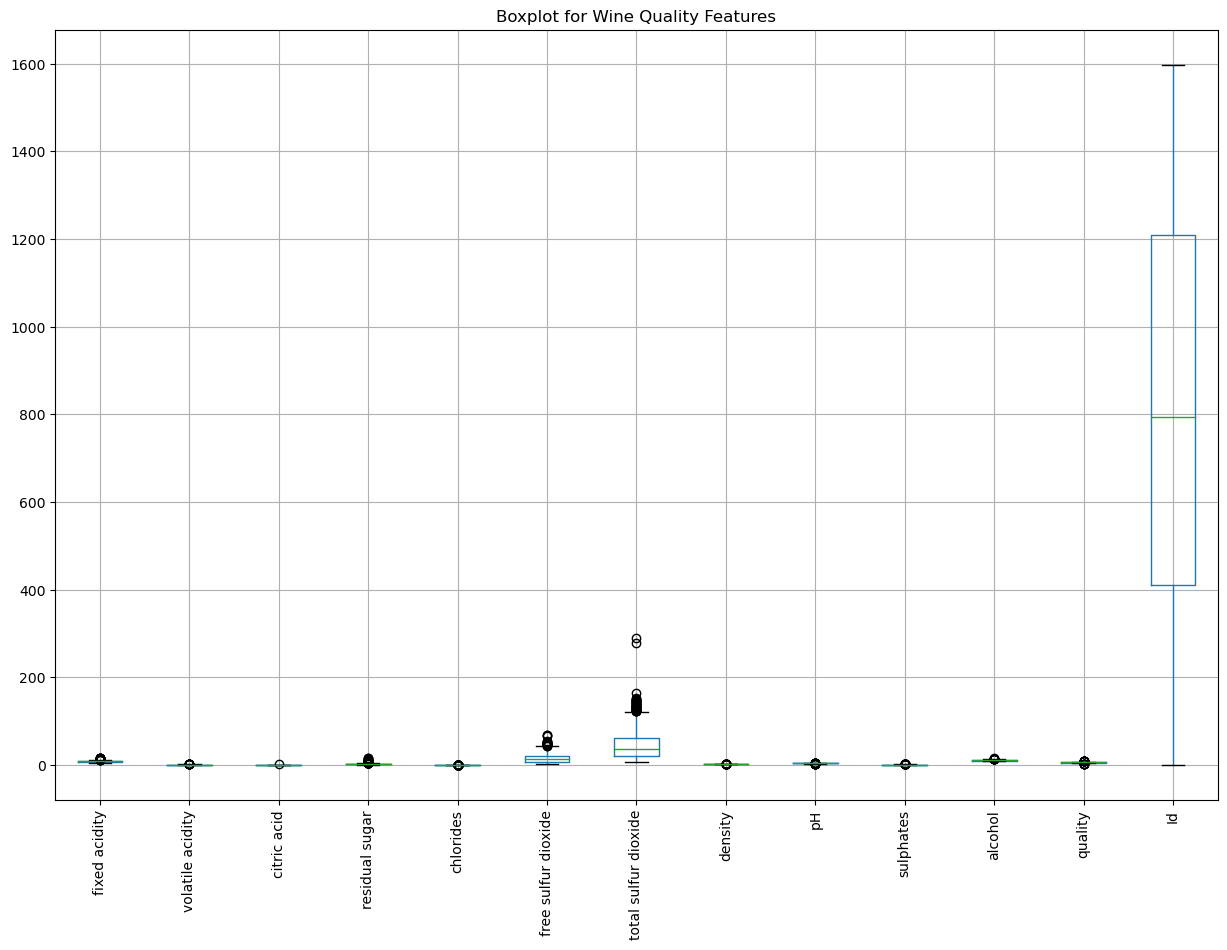

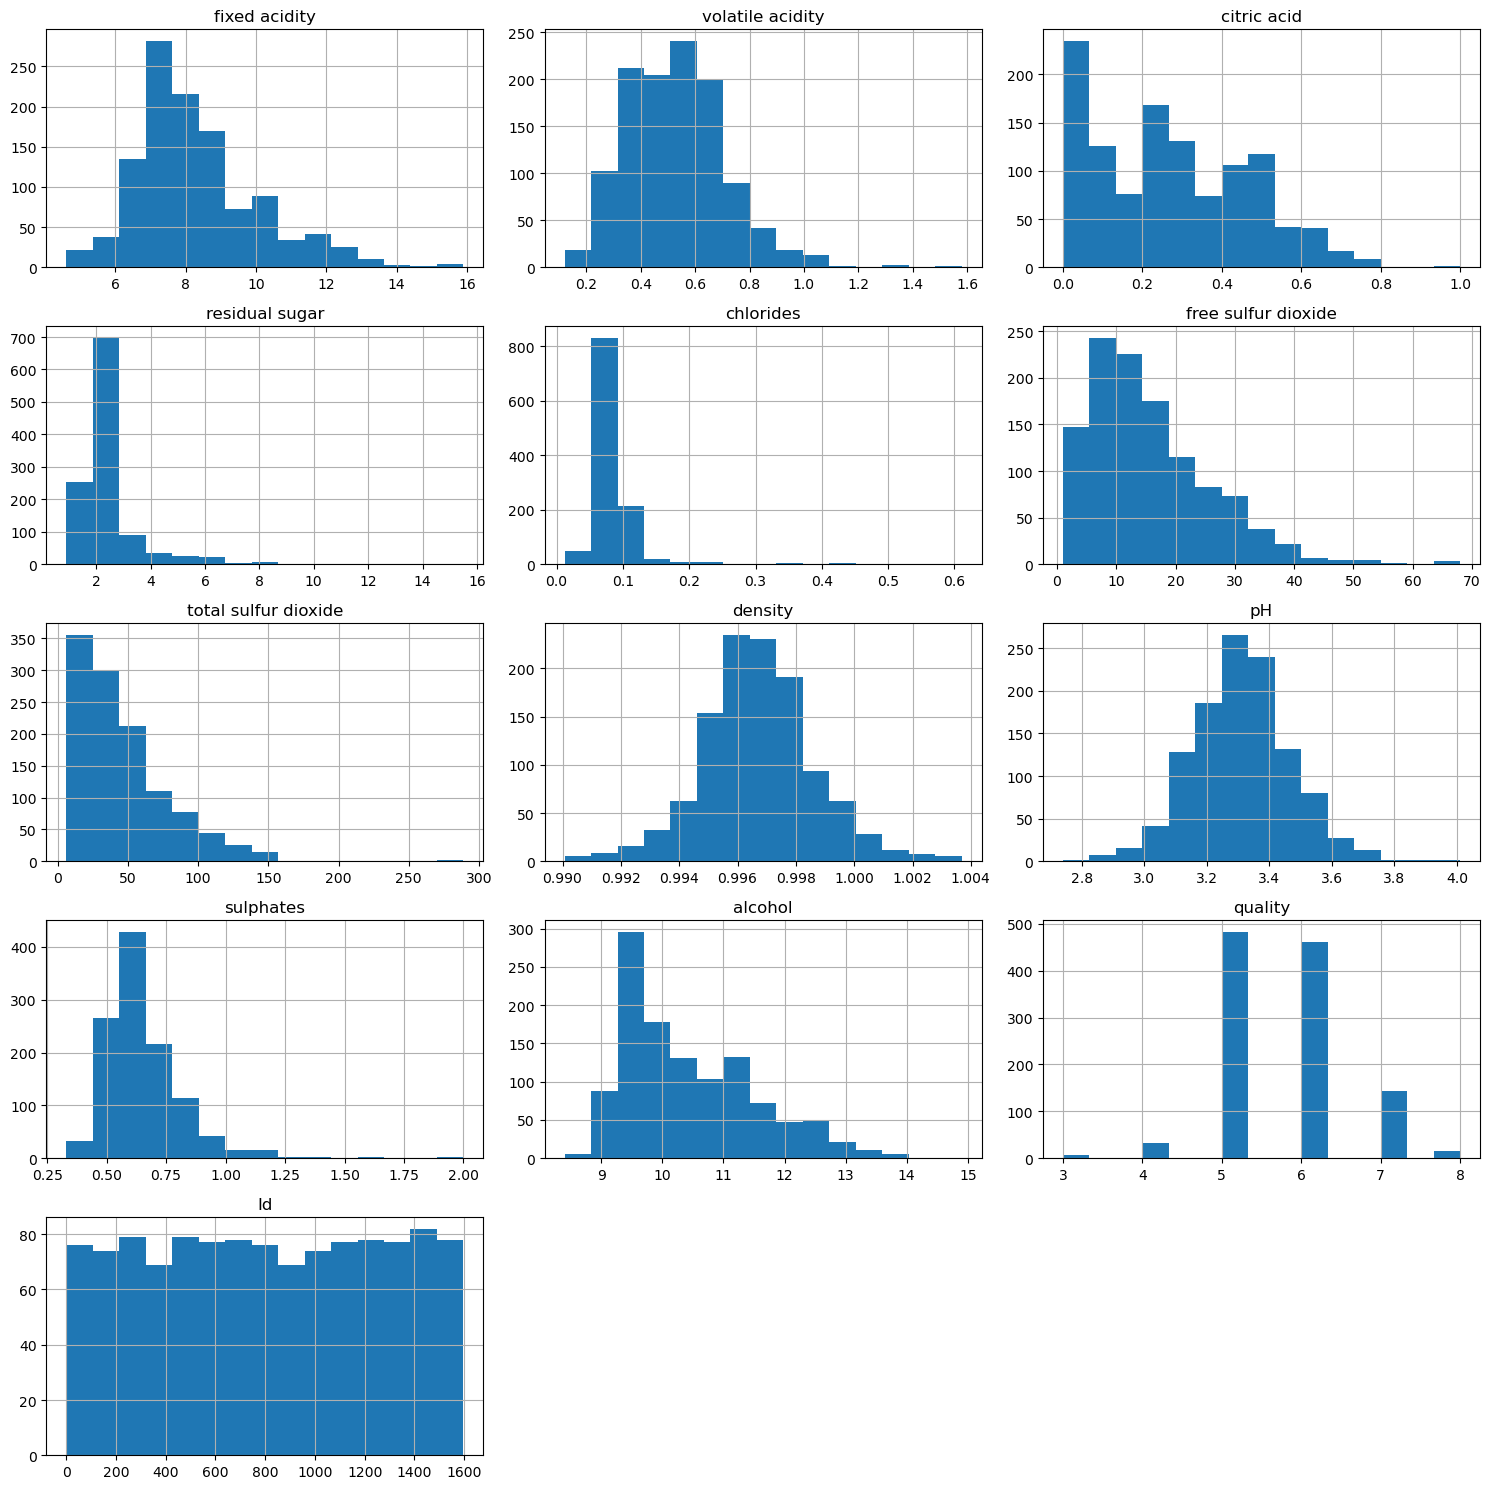

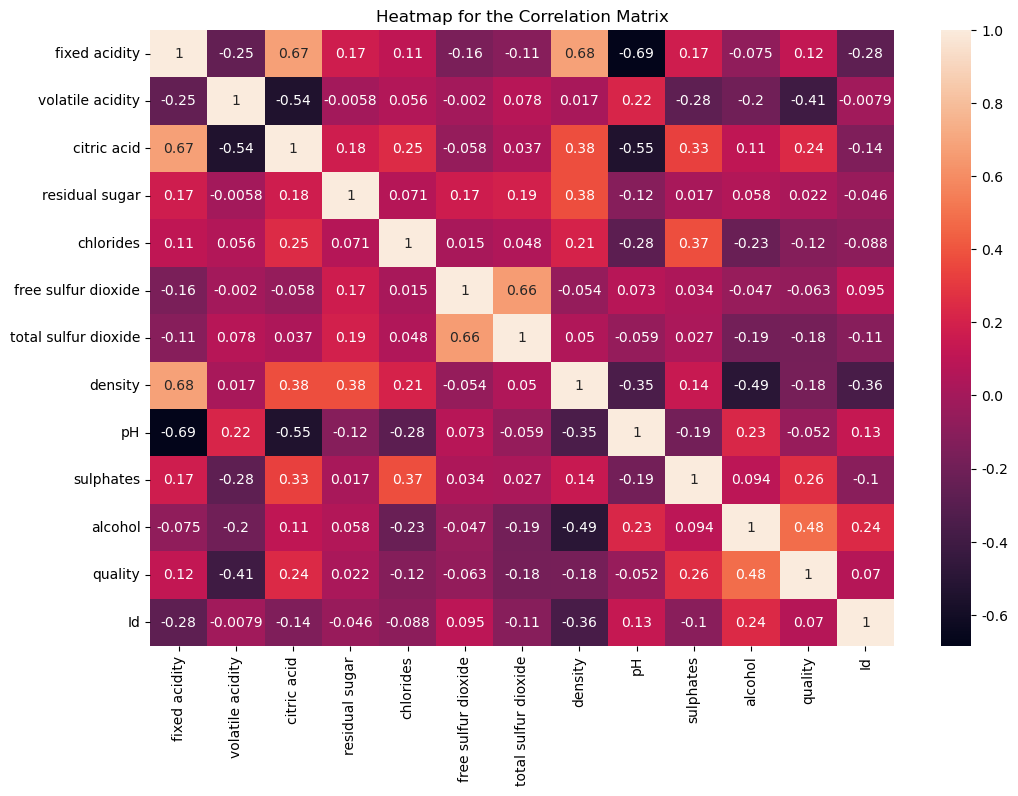

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 데이터 로드 및 전처리
def load_and_preprocess_data(filepath):
    # CSV 파일 불러오기
    data = pd.read_csv(filepath)
    
    # 결측값 검사
    missing_values = data.isnull().sum()
    
    # 누락된 값이 있으면 채우거나 삭제한다
    # 결측값을 가진 행을 삭제하기로 선택했다고 가정한다
    if missing_values.any():
        data = data.dropna()

    # 피쳐와 태그 분리
    X = data.drop(columns=['quality', 'Id'])
    y = data['quality']
    
    # 표준화된 처리
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    return X_scaled, y

def eda(data):
    # describe( )를 사용한다
    print(data.describe())
    
    # 상자 그림을 그리다
    plt.figure(figsize=(15, 10))
    data.boxplot()
    plt.xticks(rotation=90)
    plt.title('Boxplot for Wine Quality Features')
    plt.show()
    
    # 히스토그램 그리기
    data.hist(bins=15, figsize=(15, 15), layout=(5, 3))
    plt.tight_layout()
    plt.show()
    
    # 입력변수와 출력변수의 상관계수를 계산
    correlation_matrix = data.corr()
    plt.figure(figsize=(12, 8))
    sns.heatmap(correlation_matrix, annot=True)
    plt.title('Heatmap for the Correlation Matrix')
    plt.show()



# 데이터 집합의 구분
def split_data(X, y):
    # 데이터를 훈련 세트와 테스트 세트로 나누다
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test

# 데이터 로드
filepath = 'WineQT.csv'

# 데이터 전처리 로드
X, y = load_and_preprocess_data(filepath)

# EDA 진행하기
eda(pd.read_csv(filepath))  # 원래 표준화되지 않은 데이터를 사용하여 EDA 수행

# 데이터  구분
X_train, X_test, y_train, y_test = split_data(X, y)


In [4]:
import pandas as pd

# 데이터 로드
df = pd.read_csv('WineQT.csv')

# 'quality' 열의 고유값 가져오기
unique_quality_values = df['quality'].unique()

# 고유값 인쇄
print(unique_quality_values)


[5 6 7 4 8 3]


# Building Model

In [16]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np

# 매핑 함수를 정의하여 quality 열의 값을 변환하다
def map_quality(quality):
    mapping = {3: 0, 4: 1, 5: 2, 6: 3, 7: 4, 8: 5}
    return quality.map(mapping)

# X_train, X_test, y_train, y_test가 정의되고 준비되었다고 가정하면, 교차 엔트로피 손실 함수의 요구 사항을 충족하기 위해 원래 태그에서 0으로 시작하는 연속 정수에 quality 값을 매핑합니다.
y_train_mapped = map_quality(y_train)
y_test_mapped = map_quality(y_test)

# 데이터를 PyTorch 텐서로 변환
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_mapped.values, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_mapped.values, dtype=torch.long)

# 사용자 정의 데이터 만들기
class WineDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# DataLoader를 사용하여 대량으로 데이터 로드하기
train_dataset = WineDataset(X_train_tensor, y_train_tensor)
test_dataset = WineDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)
  
class WineQualityNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(WineQualityNet, self).__init__()
        # 더 많은 레이어와 더 많은 셀
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 256)
        self.dropout1 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(256, 128)
        self.dropout2 = nn.Dropout(0.5)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, output_dim)  # 출력 레이어의 크기는 품질 카테고리의 수량

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x


# 인스턴스화 모형
model = WineQualityNet(X_train_tensor.shape[1],6)

# 손실 함수 및 최적화 도구 정의
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# 모형 훈련 함수
def train_model(model, train_loader, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        total_accuracy = 0

        for batch in train_loader:
            features, labels = batch
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_accuracy += (predicted == labels).sum().item()

        avg_loss = total_loss / len(train_loader.dataset)
        avg_accuracy = total_accuracy / len(train_loader.dataset)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {avg_accuracy:.4f}')

# 모형 평가 함수
def evaluate_model(model, test_loader):
    model.eval()
    total_accuracy = 0

    with torch.no_grad():
        for batch in test_loader:
            features, labels = batch
            outputs = model(features)
            _, predicted = torch.max(outputs.data, 1)
            total_accuracy += (predicted == labels).sum().item()

    avg_accuracy = total_accuracy / len(test_loader.dataset)
    print(f'Accuracy: {avg_accuracy:.4f}')

# 모형 훈련하기
train_model(model, train_loader, criterion, optimizer, num_epochs=100)

# 모형 평가하기
evaluate_model(model, test_loader)

Epoch [1/100], Loss: 0.0573, Accuracy: 0.0514
Epoch [2/100], Loss: 0.0556, Accuracy: 0.3195
Epoch [3/100], Loss: 0.0523, Accuracy: 0.4398
Epoch [4/100], Loss: 0.0467, Accuracy: 0.4803
Epoch [5/100], Loss: 0.0417, Accuracy: 0.5088
Epoch [6/100], Loss: 0.0396, Accuracy: 0.4869
Epoch [7/100], Loss: 0.0388, Accuracy: 0.4847
Epoch [8/100], Loss: 0.0372, Accuracy: 0.5088
Epoch [9/100], Loss: 0.0367, Accuracy: 0.5525
Epoch [10/100], Loss: 0.0363, Accuracy: 0.5416
Epoch [11/100], Loss: 0.0360, Accuracy: 0.5514
Epoch [12/100], Loss: 0.0349, Accuracy: 0.5580
Epoch [13/100], Loss: 0.0342, Accuracy: 0.5722
Epoch [14/100], Loss: 0.0347, Accuracy: 0.5667
Epoch [15/100], Loss: 0.0339, Accuracy: 0.5656
Epoch [16/100], Loss: 0.0337, Accuracy: 0.5766
Epoch [17/100], Loss: 0.0335, Accuracy: 0.5700
Epoch [18/100], Loss: 0.0331, Accuracy: 0.5711
Epoch [19/100], Loss: 0.0333, Accuracy: 0.5744
Epoch [20/100], Loss: 0.0334, Accuracy: 0.5821
Epoch [21/100], Loss: 0.0331, Accuracy: 0.5864
Epoch [22/100], Loss: 